In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.ticker as mticker

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Read the data and skip the first two rows as they have no valuable data
df = pd.read_csv("NVIDIA_STOCK.csv", skiprows=[1, 2])

# Renaming columns and changing date data type to Date
df = df.rename(columns={"Price": "Date"})
df = df.rename(columns={"Adj Close": "AdjClose"})
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

#Dropping the irrelevant features (Close = closing price)
df = df.drop(columns=["Close"])

#Creating a 7 day and a 30 day moving averages for features
df['MA_7'] = df['AdjClose'].rolling(window=7).mean()
df['MA_30'] = df['AdjClose'].rolling(window=30).mean()
df.dropna(inplace=True)

features = ["Open","High","Low","Volume","MA_7","MA_30"]
X = df[features]
y = df["AdjClose"]

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1668 entries, 29 to 1696
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1668 non-null   datetime64[ns]
 1   AdjClose  1668 non-null   float64       
 2   High      1668 non-null   float64       
 3   Low       1668 non-null   float64       
 4   Open      1668 non-null   float64       
 5   Volume    1668 non-null   int64         
 6   MA_7      1668 non-null   float64       
 7   MA_30     1668 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 117.3 KB


,Date,AdjClose,High,Low,Open,Volume,MA_7,MA_30
29,2018-02-13,5.752888,5.86250,5.63125,5.66400,625524000,5.576000,5.630707
30,2018-02-14,5.970263,6.06475,5.76375,5.77500,744988000,5.673930,5.665386
31,2018-02-15,6.095891,6.20925,6.03800,6.11975,698900000,5.747836,5.693438
32,2018-02-16,6.030109,6.25000,6.08675,6.13500,637656000,5.800970,5.718374
33,2018-02-20,6.159693,6.29675,6.11500,6.11875,686240000,5.912466,5.746137


In [3]:
#Split the data
n = len(df)
train_end = int(0.6 * n)
val_end = int(0.8 * n)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

In [4]:
#Train the Random forest
rf = RandomForestRegressor(n_estimators = 200, random_state = 42, n_jobs = 1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, n_jobs=1, random_state=42)

In [5]:
#Predictions
y_train_pred = rf.predict(X_train)
y_val_pred = rf.predict(X_val)
y_test_pred = rf.predict(X_test)

In [6]:
#Mean squared error
mse_train = mean_squared_error(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

#Root mean squared error
rmse_train = np.sqrt(mse_train)
rmse_val = np.sqrt(mse_val)
rmse_test = np.sqrt(mse_test)


print("Train MSE:", rmse_train)
print("Validation MSE:", rmse_val)
print("Test MSE:", rmse_test)

print("Train RMSE:", rmse_train)
print("Validation RMSE:", rmse_val)
print("Test RMSE:", rmse_test)

Train MSE: 0.08500161121663853
Validation MSE: 0.9269972001132736
Test MSE: 52.367967493112126
Train RMSE: 0.08500161121663853
Validation RMSE: 0.9269972001132736
Test RMSE: 52.367967493112126


Prediction for the next day:  119.60314701080323


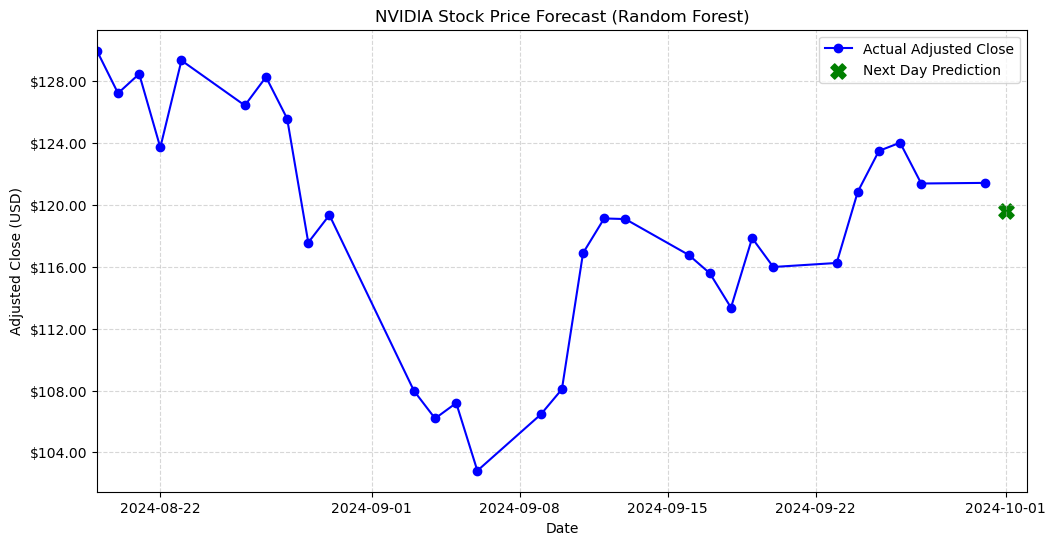

In [7]:
#Calculate the prediction for the next day and plot it
rf.fit(X.iloc[:-1], y.iloc[:-1])
X_last = X.iloc[[-1]]
last_date = df["Date"].iloc[-1]
next_pred = rf.predict(X_last)[0]
print("Prediction for the next day: ", next_pred)

next_day = last_date + pd.Timedelta(days=1)
plt.figure(figsize=(12,6))

# Plot previous actual prices (e.g. last 30 days for clarity)
lookback = 30
plt.plot(df["Date"].iloc[-lookback:], df["AdjClose"].iloc[-lookback:], 
         "o-", color="blue", label="Actual Adjusted Close")

# Add the predicted next day price
plt.scatter(next_day, next_pred, color="green", s=120, label="Next Day Prediction", marker="X")

# --- 5. Styling ---
plt.title("NVIDIA Stock Price Forecast (Random Forest)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close (USD)")

# Format y-axis as nice currency
ax = plt.gca()
ax.yaxis.set_major_locator(mticker.MaxNLocator(8))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("${x:,.2f}"))

# Add grid and legend
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

# --- 6. Extend x-axis to show the prediction day ---
plt.xlim(df["Date"].iloc[-lookback], next_day + pd.Timedelta(days=1))

plt.show()

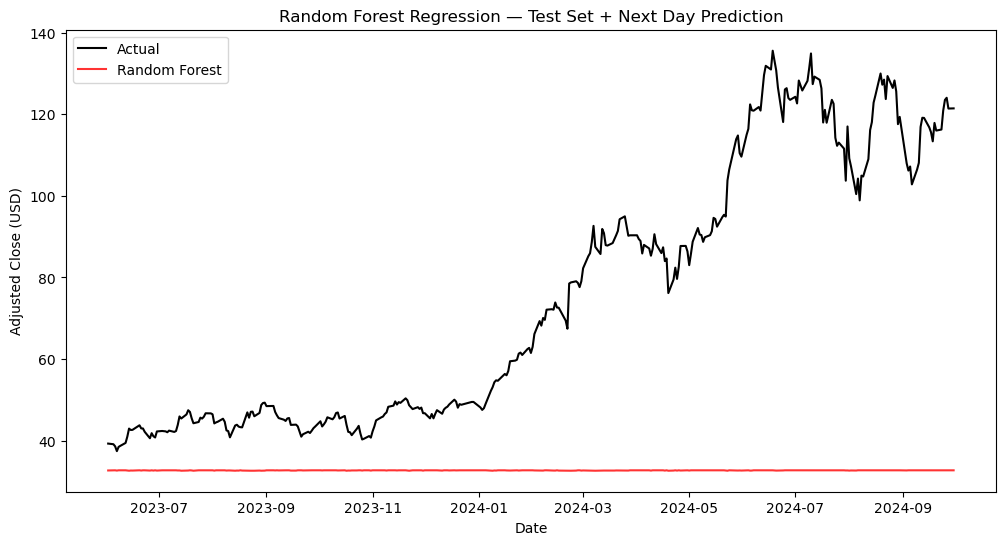

In [8]:
#Plot the data
plt.figure(figsize=(12,6))
plt.plot(df["Date"].iloc[val_end:val_end+len(y_test)], y_test.values, label="Actual", color="black")
plt.plot(df["Date"].iloc[val_end:val_end+len(y_test)], y_test_pred, label="Random Forest", color="red", alpha=0.8)
plt.legend()
plt.title("Random Forest Regression — Test Set + Next Day Prediction")
plt.xlabel("Date")
plt.ylabel("Adjusted Close (USD)")
plt.show()

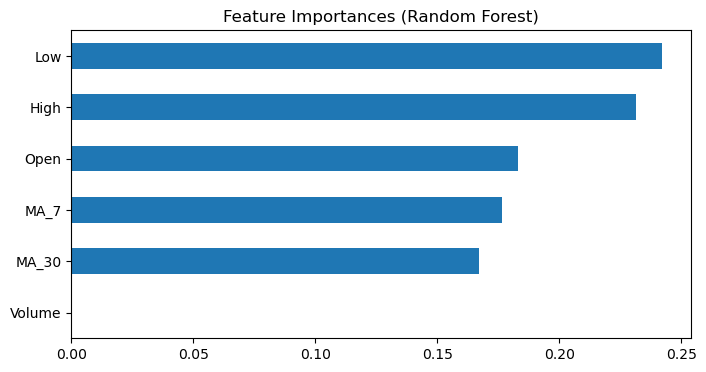

In [9]:
importances = pd.Series(rf.feature_importances_, index=features)
importances.sort_values().plot(kind="barh", figsize=(8,4))
plt.title("Feature Importances (Random Forest)")
plt.show()